
### Examining racial discrimination in the US job market

#### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

#### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes.

#### Exercise
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Discuss statistical significance.

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [12]:
import pandas as pd
import numpy as np
from scipy import stats
#from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 65 columns):
id                    4870 non-null object
ad                    4870 non-null object
education             4870 non-null int8
ofjobs                4870 non-null int8
yearsexp              4870 non-null int8
honors                4870 non-null int8
volunteer             4870 non-null int8
military              4870 non-null int8
empholes              4870 non-null int8
occupspecific         4870 non-null int16
occupbroad            4870 non-null int8
workinschool          4870 non-null int8
email                 4870 non-null int8
computerskills        4870 non-null int8
specialskills         4870 non-null int8
firstname             4870 non-null object
sex                   4870 non-null object
race                  4870 non-null object
h                     4870 non-null float32
l                     4870 non-null float32
call                  4870 non-null float32
city        

In [31]:
pd.Series(data.race, data.call).head(10)

call
0.0    w
0.0    w
0.0    w
0.0    w
0.0    w
0.0    w
0.0    w
0.0    w
0.0    w
0.0    w
Name: race, dtype: object

## 1. What test is appropriate for this problem? Does CLT apply?

We can view the data as the result of a ** Bernulli experiment**, i.e. observing a binary random variable of getting and not getting a call with the probabilities $p$ and $1-p$, respectively, repeated 4870 times (the size of the sample).

The distribution of the expected number of calls would follow a binomial distribution that we want to plot. 

Some data exploration first. For convenience let's add an extra column **race_bool** with **True** for black sounding names and **False** otherwise.

In [32]:
data['race_bool'] = pd.Series(False, index=data.index)
# The following line 
# data.race_num[data.race == 'b'] = 1
# works but slow and produces a SettingWithCopyWarning: 
# A value is trying to be set on a copy of a slice from a DataFrame

data.loc[data.race == 'b','race_bool'] = True

If we see getting vs. not getting a call as a **Bernoulli experiment** then the probability for getting a call **regardless the race** is

In [72]:
p_call_total = sum(data.call) / len(data) 
p_call_total

0.080492813141683772

Whereas the **conditional probability** for getting a call if the name sounds black is

In [36]:
p_call_black = sum(data.call[data.race_bool]) / sum(data.race_bool)
p_call_black

0.064476386036960986

The **total number of black sounding names** is

In [59]:
sum(data.race_bool)

2435

The **number of black sounding names having received a call** is

In [62]:
sum(data.call[data.race_bool])

157.0

We can plot the **binomial distribution** now as

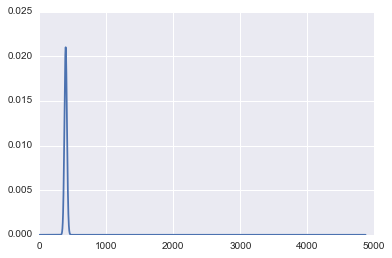

In [45]:
ntrials = len(data) 
xx = np.linspace(0,ntrials,ntrials+1)
pmf = stats.binom.pmf(xx,ntrials,p_call_total)
plt.plot(xx,pmf)

The De Moivre–Laplace theorem (https://en.wikipedia.org/wiki/De_Moivre–Laplace_theorem), a special case of the CLT, says that for a growing number $n$ of Bernulli trials the **probability mass function of the binomial distribution** converges against the **probability density function of the normal distribution** with mean $np$ and standard deviation $\sqrt{np(1-p)}$, as $n$ grows large, assuming $p$ is not $0$ or $1$. Comparing the plots we see that the normal distribution is a good approximation for the binomial one, indeed.

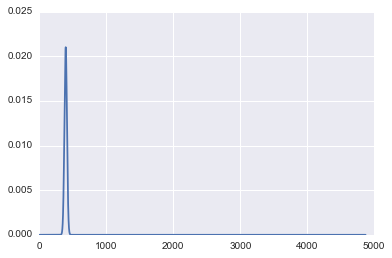

In [46]:
mean = ntrials * p_call_total
stdev = (ntrials * p_call_total * (1 - p_call_total))**0.5
plt.plot(xx, stats.norm.pdf(xx, mean, stdev))


plt.show()

## 2. What are the null and alternate hypotheses?

The **null hypothesis H0** is there is no bias and the number of people marked as 'b' follows the same distribution as the rest. The **alternative hypothesis** will be that there is a bias and black sounding names receive significally less calls.

## 3. Compute margin of error, confidence interval, and p-value.

Let's now evalutate the **0.5% and 99.5% percentiles** of this normal distribution.

In [60]:
conf_interval = stats.norm.ppf([0.005,0.995], loc=mean, scale=stdev)
conf_interval

array([ 343.09675509,  440.90324491])

It means that with a **99% probability** the number of people called for a sample of 4870 canditates should be between $[ 343.09675509,  440.90324491]$.

There were 2435 names marked with 'b'. **If H0 holds** and there is no bias, the number of people with black sounding names who have received a call should lie within the confidence interval calculated above scaled down by the factor $\frac{2435}{4870}=0.5$ due to the smaller size of the sample.

In [63]:
conf_interval_b = conf_interval * 0.5
conf_interval_b

array([ 171.54837755,  220.45162245])

The number 157 is outside this interval. **We must reject the null hypothesis** and coclude that with a 99% probability there was a bias agaist calling people with black sounding names.

The **margin of error** is usually defined as the half length of the confidence interval, i.e.

In [75]:
(conf_interval_b[1] - conf_interval_b[0]) / 2

24.451622454403321

The **p-Value** for the observed sample mean of the number of calls received by the 'b' names is ...

note that we have to scale down the mean and the standard deviation by the factor 0.5 due to the half size of the 'b' sample compared to the total sample.

In [80]:
stats.norm.cdf(sum(data.call[data.race_bool]), loc=mean / 2, scale=stdev / 2) 

1.9919434187925614e-05

In [96]:
np.random.seed(7654567)  # fix seed to get the same result
rvs = stats.norm.rvs(loc=5, scale=10, size=50)

In [109]:
ttest_res = stats.ttest_1samp(rvs,5.0)
ttest_res

Ttest_1sampResult(statistic=-1.6412624074367159, pvalue=0.10714702733404805)

In [105]:
#stats.norm.cdf(-0.68014479,5,10)
t_stat = (rvs.mean() - 5) / (rvs.std() / (len(rvs)-1)**0.5)
t_stat

-1.6412624074367159

In [110]:
stats.norm.cdf(t_stat,0,1) *2

0.10074295602576114

In [113]:

stats.norm.cdf(ttest_res[0],0,1) *2  == stats.norm.cdf(t_stat,0,1) *2

True

In [116]:
stats.norm.ppf(ttest_res[1] / 2, 0, 1)

-1.6111500244490007

## A different approach

We can also treat the data from the beginning on as two different samples and test the **null hypothesis** if they are from the same distribution using SciPy's *stats.ttest_ind* test.

Reference / examples
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind
http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-24.html

In [121]:
sample_b = data.call[data.race_bool]
sample_w = data.call[np.invert(data.race_bool)]

In [126]:
ttest_ind_res = stats.ttest_ind(sample_b, sample_w, equal_var = False)
ttest_ind_res

Ttest_indResult(statistic=-4.1147052908617514, pvalue=3.9429415136459352e-05)

Since our p-value is smaller than 0.001 we can reject the null hypothesis with at least 99.9% probability